# Rat Sightings in New York City

The purpose of this project is to....

In [73]:
###GENERAL LIBRARIES####

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from census import Census
import datetime as datetime
import calendar
import gmaps
from config import gkey
gmaps.configure(api_key=gkey)

In [5]:
###IMPORTING & CLEANING DATA###

rat = "Rat_Sightings.csv"
temp = "laguardia_jfk.csv"
temp_df = pd.read_csv(temp)
rat_df = pd.read_csv(rat, low_memory=False)
rat_df['converted_date'] = pd.to_datetime(rat_df['Created Date'],infer_datetime_format=True)
rat_df.drop(rat_df[rat_df.Borough=='Unspecified'].index, inplace=True)
rat_df = rat_df[(rat_df['converted_date'] < '2018-01-01') ]
rat_df = rat_df [["Created Date", "Closed Date", "Location Type","Borough","Latitude",
                    "Longitude", "converted_date"]]
clean_df = rat_df

In [6]:
###IMPORTING AND CLEANING TEMPERATURE DATA###

temp_df.drop(temp_df[temp_df.STATION=="USW00094789"].index, inplace=True)
temp_df['converted_date']=pd.to_datetime(temp_df['DATE'],infer_datetime_format=True)
temp_df['Year-Week'] = temp_df['converted_date'].dt.strftime('%Y-%U')
temp_df = temp_df[['Year-Week', 'TMAX']]
temp_df.rename(columns={'Year-Week': 'Year-Week', 'TMAX': 'temp'}, inplace=True)
time_series_temp = temp_df.groupby('Year-Week').agg('mean')
time_series_temp = pd.DataFrame(time_series_temp).reset_index()

In [7]:
###CREATING SEASONS & MONTH/YEAR VARIABLES FOR GRAPHING###

rat_df['month'] = rat_df['converted_date'].dt.month
rat_df['Month'] = rat_df['month'].apply(lambda x: calendar.month_abbr[x])
rat_df['month_year'] = rat_df.converted_date.dt.to_period('M')
rat_df['season'] = ""
seasons = ['Winter', 'Winter', 'Spring', 'Spring', 'Spring', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Fall', 'Winter']
month_to_season = dict(zip(range(1,13), seasons))
rat_df['season'] = rat_df['month'].replace(month_to_season)
clean_df = rat_df

In [8]:
###BASIC DESCRIPTIVES & FILE STRUCTURE###

print(clean_df.shape)
print(clean_df.describe())
print(clean_df.head())

(106640, 11)
            Latitude      Longitude          month
count  105895.000000  105895.000000  106640.000000
mean       40.739312     -73.934165       6.652138
std         0.082147       0.070378       3.049816
min        40.499502     -74.254437       1.000000
25%        40.679719     -73.966241       4.000000
50%        40.725009     -73.938222       7.000000
75%        40.815363     -73.899878       9.000000
max        40.912869     -73.701632      12.000000
             Created Date Closed Date            Location Type    Borough  \
0  01/01/2010 11:20:45 AM         NaN      1-2 Family Dwelling     QUEENS   
1  01/02/2010 12:50:36 AM         NaN      Commercial Building  MANHATTAN   
2  01/01/2010 03:05:37 PM         NaN  3+ Family Apt. Building     QUEENS   
3  01/01/2010 08:52:19 PM         NaN    Other (Explain Below)   BROOKLYN   
4  01/01/2010 04:14:27 PM         NaN  3+ Family Apt. Building      BRONX   

    Latitude  Longitude      converted_date  month Month month_ye

In [9]:
###GENERATING BOROUGH COUNTS###

clean_df['Borough'].value_counts()

BROOKLYN         36433
MANHATTAN        27984
BRONX            21661
QUEENS           15474
STATEN ISLAND     5088
Name: Borough, dtype: int64

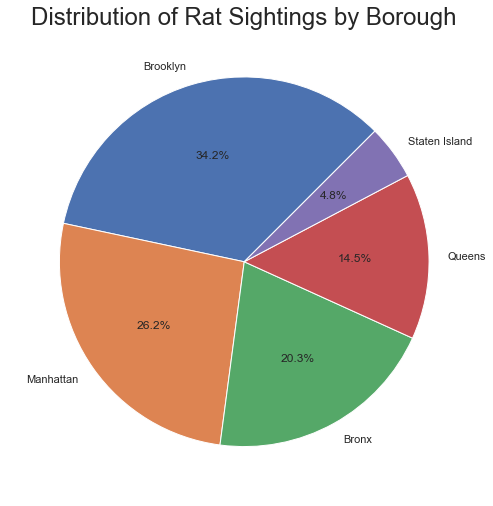

In [18]:
###GENERATING PIE CHART OF RAT SIGHTINGS BY BOROUGH###

labels = ["Brooklyn", "Manhattan", "Bronx",'Queens', 'Staten Island']
sizes = clean_df['Borough'].value_counts()
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.pie(sizes, labels=labels, startangle=45, autopct='%.1f%%')
plt.title('Distribution of Rat Sightings by Borough', fontsize = 24)
plt.show(fig)
fig.savefig("sightings_borough.png")

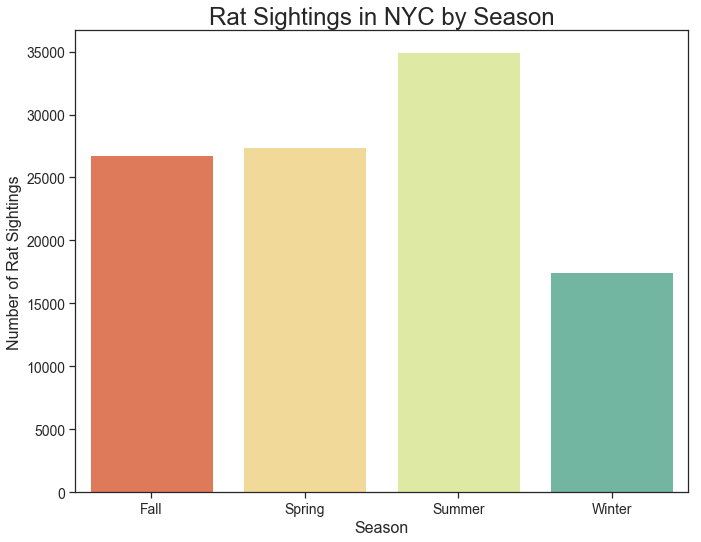

In [32]:
###SET UP DATA FOR COUNTS OF SIGHTINGS BY SEASON & CREATE GRAPH###

seasons = clean_df.groupby('season').agg('count').reset_index()
#source_data = pd.DataFrame(seasons).reset_index()

sns.set(style="whitegrid")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.title('Rat Sightings in NYC by Season', fontsize=24)
plt.tick_params(labelsize=14)
fig = sns.barplot(x='season',y='month_year', data=seasons, palette = 'Spectral')
plt.xlabel("Season", fontsize = 16)
plt.ylabel("Number of Rat Sightings", fontsize = 16)

plt.show(fig)
fig.figure.savefig("seasonal_sightings.png")

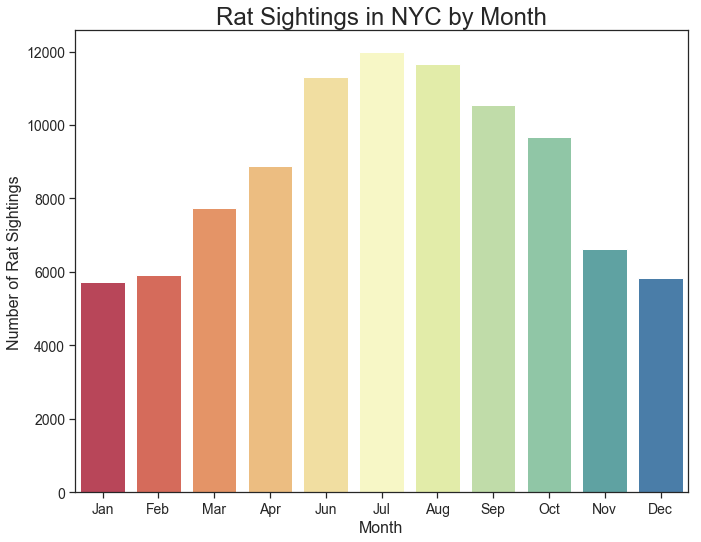

In [44]:
###SET UP DATA FOR MONTHLY COUNTS OF SIGHTINGS & CREATE GRAPH###

months = clean_df.groupby('Month').agg('count')
source_data = pd.DataFrame(months).reset_index()

sns.set(style="whitegrid")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.title('Rat Sightings in NYC by Month', fontsize = 24)
fig = sns.barplot(x='Month',y='month_year', data=source_data, palette = 'Spectral', 
                 order = ['Jan', 'Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month", fontsize= 16)
plt.ylabel("Number of Rat Sightings", fontsize=16)
plt.tick_params(labelsize=14)
plt.show(fig)
fig.figure.savefig("monthly.png")

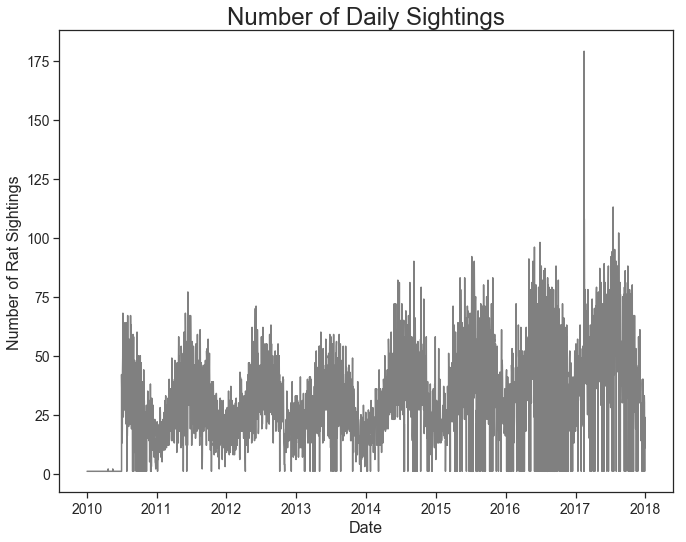

In [45]:
###SET UP DATA FOR DAILY COUNTS OF SIGHTINGS & CREATE GRAPH###

time_series = clean_df.groupby('converted_date').agg('count')
source_data = pd.DataFrame(time_series).reset_index()

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.title('Number of Daily Sightings', fontsize=24)
fig = sns.lineplot(x='converted_date', y='month', data=source_data, color="gray")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Number of Rat Sightings", fontsize=16)
plt.tick_params(labelsize=14)

plt.show(fig)
fig.figure.savefig("daily_over_time.png")

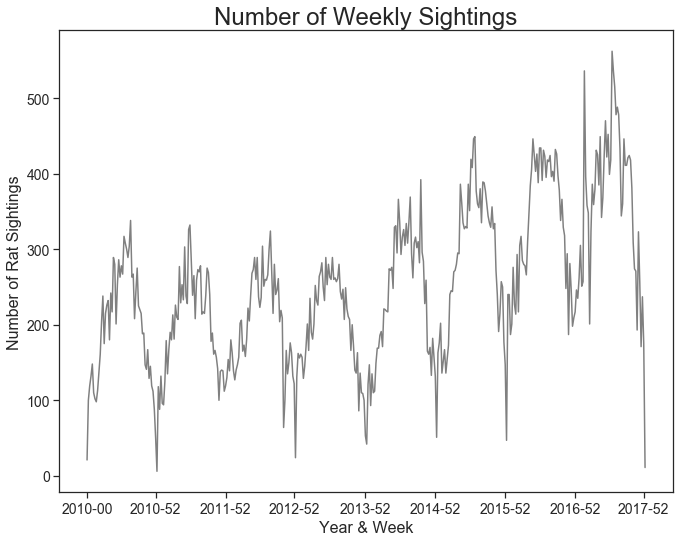

In [47]:
###SET UP DATA FOR WEEKLY COUNTS OF SIGHTINGS & CREATE GRAPH###
clean_df['Year-Week'] = clean_df['converted_date'].dt.strftime('%Y-%U')
time_series = clean_df.groupby('Year-Week').agg('count')
source_data = pd.DataFrame(time_series).reset_index()

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
fig = sns.lineplot(x='Year-Week', y='month', data=source_data, color="gray")
plt.title('Number of Weekly Sightings', fontsize=24)
plt.xlabel("Year & Week", fontsize=16)
plt.ylabel("Number of Rat Sightings", fontsize =16)
plt.setp(ax,xticks=[0,52, 105, 157, 211, 264, 317, 370, 422])
plt.tick_params(labelsize=14)

plt.show(fig)
fig.figure.savefig("weekly_over_time.png")

In [35]:
###MERGING TEMP DATA AND SIGHTING DATA###

result = pd.merge(source_data, time_series_temp, on='Year-Week')

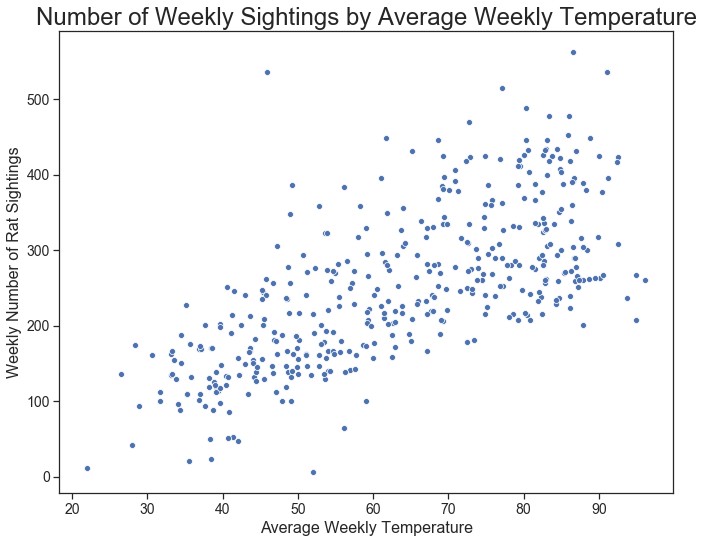

In [48]:
###SCATTERPLOT OF TEMP AND SIGHTINGS###

sns.set(style="whitegrid")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.title('Number of Weekly Sightings by Average Weekly Temperature', fontsize = 24)
fig = sns.scatterplot(x='temp',y='month', data=result, palette = 'Spectral')
plt.xlabel("Average Weekly Temperature", fontsize=16)
plt.ylabel("Weekly Number of Rat Sightings", fontsize=16)
plt.tick_params(labelsize=14)

plt.show(fig)
fig.figure.savefig("temp_sightings.png")

In [37]:
corr = result.corr()

In [61]:
###BREAKDOWN OF RAT SIGHTING DATA BY BUILDING TYPE FOR BROOKLYN###
brooklyn_df = clean_df[clean_df["Borough"] == "BROOKLYN"]
rat_count_brooklyn = brooklyn_df["Location Type"].value_counts()
total_brooklyn_rats = rat_count_brooklyn.sum()
rat_percent_brooklyn = rat_count_brooklyn/total_brooklyn_rats * 100

labels = ["3+ Family Apt. Building", "1-2 Family Dwelling", "Other", "3+ Family Mixed Use Building", "Commercial Building", "Vacant Lot", "Construction Site", "Vacant Building", "1-2 Family Mixed Use Building", "Parking Lot/Garage", "Catch Basin/Sewer", "Public Garden", "Government Building", "School", "Day Care", "Single Room Occupancy", "Hospital", "Office Building", "Public Stairs", "Summer Camp"]
colors = ["dodgerblue", "orange", "green", "red", "yellow", "lightblue", "purple", "pink", "yellowgreen", "lightcoral", "gold", "maroon", "sienna", "silver", "chartreuse", "aqua", "gray", "crimson", "turquoise", "khaki"]
percentages = ["39.5%", "20.3%", "14.8%", "6.5%", "4.7%", "4.2%", "2.8%", "2.2%", "2.0%", "0.8%", "0.6%", "0.3%", "0.2%", "0.2%", "0.1%", "0.1%", "0.1%", "0.1%", "0.1%", "0.0%"]

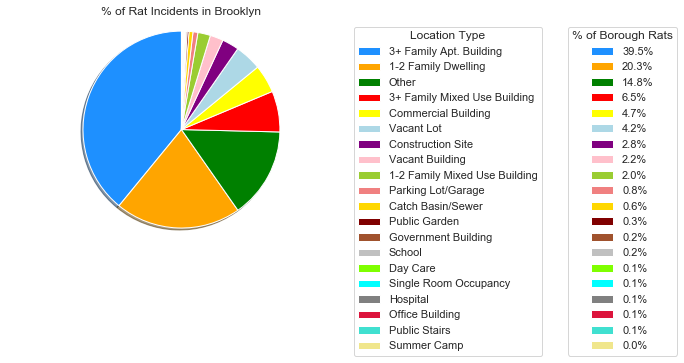

In [62]:
sizes = brooklyn_df['Location Type'].value_counts()
patches, texts = plt.pie(sizes,  colors = colors, shadow=True, startangle=90)
plt.title("% of Rat Incidents in Brooklyn")
plt.axis("equal")
first_legend = plt.legend(patches, labels, title = "Location Type", loc = "best", bbox_to_anchor = (1, 1))
ax = plt.gca().add_artist(first_legend)
second_legend = plt.legend(percentages, title = "% of Borough Rats", loc = "best", bbox_to_anchor = (2, 1))
plt.savefig('test.png', bbox_inches='tight')
plt.show()

/Users/christopherlowenkamp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


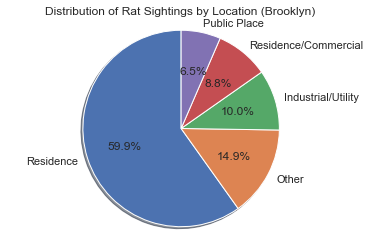

In [60]:
###BREAKDOWN OF RAT SIGHTING DATA BY LOCATION TYPE FOR BROOKLYN - SIMPLIFIED###
brooklyn_2_df = brooklyn_df
brooklyn_2_df["Location Type"] = brooklyn_2_df["Location Type"].replace({"3+ Family Apt. Building":"Residence", "1-2 Family Dwelling":"Residence", "Other (Explain Below)":"Other", "3+ Family Mixed Use Building":"Residence/Commercial", "Commercial Building":"Public Place", "Construction Site":"Industrial/Utility", "Vacant Building":"Industrial/Utility", "1-2 Family Mixed Use Building":"Residence/Commercial", "Vacant Lot":"Industrial/Utility", "1-2 Family Mixed Use Building":"Residence/Commercial", "Parking Lot/Garage":"Public Place", "Catch Basin/Sewer":"Industrial/Utility", "Public Garden":"Public Place", "Government Building":"Public Place", "School/Pre-School":"Public Place", "Day Care/Nursery":"Public Place", "Single Room Occupancy (SRO)":"Residence", "Hospital":"Public Place", "Office Building":"Public Place", "Public Stairs":"Public Place", "Summer Camp":"Public Place"})
labels = ["Residence", "Other", "Industrial/Utility", "Residence/Commercial", "Public Place"]
sizes = brooklyn_2_df["Location Type"].value_counts()
plt.pie(sizes, labels=labels, startangle=90, shadow = True, autopct='%.1f%%')
plt.axis("equal")
plt.title('Distribution of Rat Sightings by Location (Brooklyn)')
plt.show(fig)
fig.savefig("brooklyn_location_simplified.png", bbox_inches = 'tight')

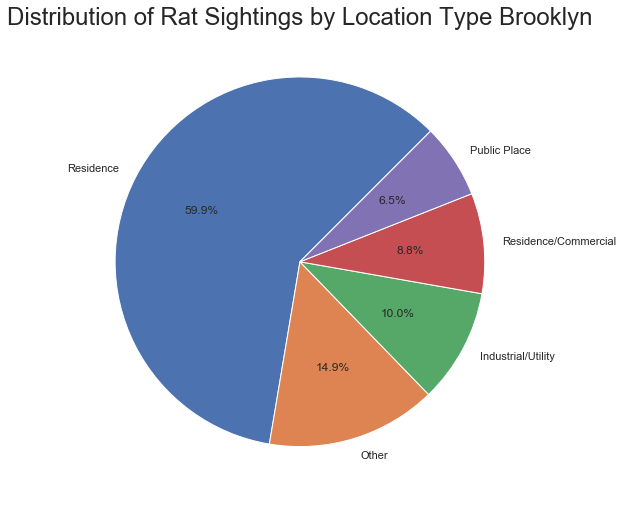

In [67]:
###GENERATING PIE CHART OF RAT SIGHTINGS BY BOROUGH###

labels = ["Residence", "Other", "Industrial/Utility", "Residence/Commercial", "Public Place"]
sizes = brooklyn_2_df["Location Type"].value_counts()
fig, ax = plt.subplots()
fig.set_size_inches(11, 8.5)
plt.pie(sizes, labels=labels, startangle=45, autopct='%.1f%%')
plt.title('Distribution of Rat Sightings by Location Type Brooklyn', fontsize = 24)
plt.show(fig)
fig.savefig("brooklyn_test.png")

In [66]:
###BREAKDOWN OF RAT SIGHTING DATA BY BUILDING TYPE - MANHATTAN###
manhattan_df = clean_df[clean_df["Borough"] == "MANHATTAN"]
rat_count_manhattan = manhattan_df["Location Type"].value_counts()
total_manhattan_rats = rat_count_manhattan.sum()
rat_percent_manhattan = rat_count_manhattan/total_manhattan_rats * 100

labels2 = ["3+ Family Apt. Building", "Other", "3+ Family Mixed Use Building", "Commercial Building", "Construction Site", "1-2 Family Dwelling", "Vacant Lot", "Catch Basin/Sewer", "Vacant Building", "Public Garden", "Parking Lot/Garage", "1-2 Family Mixed Use Building", "Government Building", "Single Room Occupancy", "School", "Public Stairs", "Day Care", "Office Building", "Hospital", "Summer Camp"]
colors2 = ["dodgerblue", "green", "red", "yellow", "purple", "orange", "lightblue", "gold", "pink", "maroon", "lightcoral", "yellowgreen", "sienna", "aqua", "silver", "turquoise", "chartreuse", "crimson", "gray", "khaki"]
percentages2 = ["47.9%", "19.3%", "11.1%", "5.8%", "3.6%", "2.8%", "1.9%", "1.8%", "1.4%", "1.2%", "1.0%", "0.8%", "0.5%", "0.3%", "0.3%", "0.2%", "0.1%", "0.1%", "0.1%", "0.0%"]

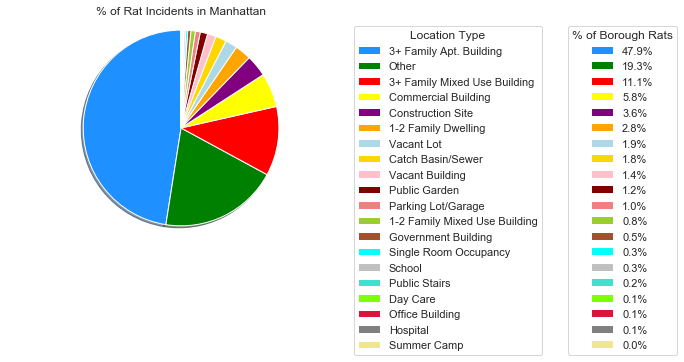

In [40]:
sizes = manhattan_df['Location Type'].value_counts()
explode = (0, .6, 0)
patches, texts = plt.pie(sizes, colors = colors2, shadow = True, startangle=90)
plt.title("% of Rat Incidents in Manhattan")
plt.axis("equal")
third_legend = plt.legend(patches, labels2, title = "Location Type", loc = "best", bbox_to_anchor = (1, 1))
ax = plt.gca().add_artist(third_legend)
fourth_legend = plt.legend(percentages2, title = "% of Borough Rats", loc = "best", bbox_to_anchor = (2, 1))
plt.show()

In [24]:
###BREAKDOWN OF RAT SIGHTING DATA BY BUILDING TYPE - BRONX###
bronx_df = clean_df[clean_df["Borough"] == "BRONX"]
rat_count_bronx = bronx_df["Location Type"].value_counts()
total_bronx_rats = rat_count_bronx.sum()
rat_percentage_bronx = rat_count_bronx/total_bronx_rats * 100

labels3 = ["3+ Family Apt. Building", "1-2 Family Dwelling", "Other", "3+ Family Mixed Use Building", "Commercial Building", "Vacant Lot", "1-2 Family Mixed Use Building", "Vacant Building", "Parking Lot/Garage", "Catch Basin/Sewer", "Construction Site", "Government Building", "Public Garden", "Public Stairs", "Single Room Occupancy", "Day Care", "School", "Office Building", "Hospital", "Summer Camp"]
colors3 = ["dodgerblue", "orange", "green", "red", "yellow", "lightblue", "yellowgreen", "pink", "lightcoral", "gold", "purple", "sienna", "maroon", "turquoise", "aqua", "chartreuse", "silver", "crimson", "gray", "khaki"]
percentages3 = ["54.8%", "16.1%", "8.9%", "8.7%", "3.2%", "2.8%", "1.3%", "1.2%", "0.8%", "0.6%", "0.5%", "0.2%", "0.2%", "0.2%", "0.1%", "0.1%", "0.1%", "0.1%", "0.0%", "0.0%"]

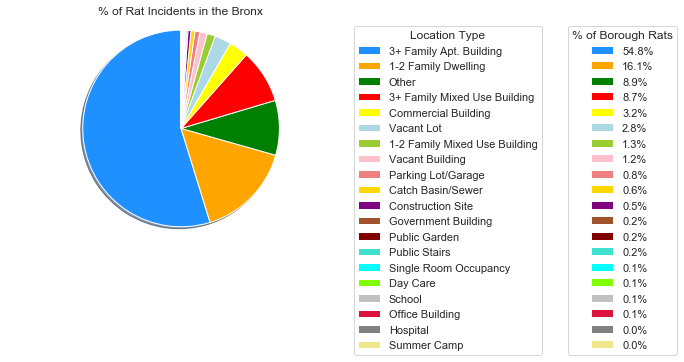

In [25]:
sizes = bronx_df['Location Type'].value_counts()
explode = (0, .6, 0)
patches, texts = plt.pie(sizes, colors = colors3, shadow=True, startangle=90)
plt.title("% of Rat Incidents in the Bronx")
plt.axis("equal")
fifth_legend = plt.legend(patches, labels3, title = "Location Type", loc = "best", bbox_to_anchor = (1, 1))
ax = plt.gca().add_artist(fifth_legend)
sixth_legend = plt.legend(percentages3, title = "% of Borough Rats", loc = "best", bbox_to_anchor = (2, 1))
plt.show()

In [26]:
###BREAKDOWN OF RAT SIGHTING DATA BY BUILDING TYPE - QUEENS###
queens_df = clean_df[clean_df["Borough"] == "QUEENS"]
rat_count_queens = queens_df["Location Type"].value_counts()
total_queens_rats = rat_count_queens.sum()
rat_percentage_queens = rat_count_queens/total_queens_rats * 100

labels4 = ["1-2 Family Dwelling", "3+ Family Apt. Building", "Other", "Commercial Building", "3+ Family Mixed Use Building", "Vacant Lot", "1-2 Family Mixed Use Building", "Vacant Building", "Construction Site", "Catch Basin/Sewer", "Parking Lot/Garage", "Public Garden", "Government Building", "Day Care", "School", "Office Building", "Public Stairs", "Hospital", "Single Room Occupancy"]
colors4 = ["orange", "dodgerblue", "green", "yellow", "red", "lightblue", "yellowgreen", "pink", "purple", "gold", "lightcoral", "maroon", "sienna", "chartreuse", "silver", "crimson", "turquoise", "gray", "aqua"]
percentages4 = ["38.7%", "21.9%", "14.4%", "7.2%", "4.4%", "3.6%", "2.9%", "2.0%", "1.5%", "1.4%", "1.1%", "0.3%", "0.2%", "0.1%", "0.1%", "0.1%", "0.1%", "0.1%", "0.0%"]

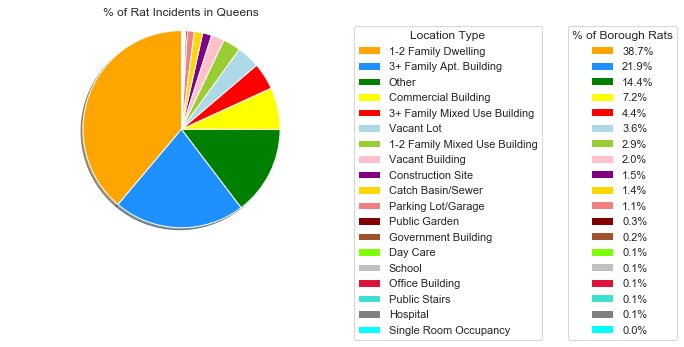

In [27]:
sizes = queens_df['Location Type'].value_counts()
explode = (0, .6, 0)
patches, texts = plt.pie(sizes, colors = colors4, shadow=True, startangle=90)
plt.title("% of Rat Incidents in Queens")
plt.axis("equal")
seventh_legend = plt.legend(patches, labels4, title = "Location Type", loc = "best", bbox_to_anchor = (1, 1))
ax = plt.gca().add_artist(seventh_legend)
eighth_legend = plt.legend(percentages4, title = "% of Borough Rats", loc = "best", bbox_to_anchor = (2, 1))
plt.show()

In [28]:
##BREAKDOWN OF RAT SIGHTING DATA BY BUILDING TYPE - STATEN ISLAND###
staten_island_df = clean_df[clean_df["Borough"] == "STATEN ISLAND"]
rat_count_staten = staten_island_df["Location Type"].value_counts()
total_staten_rats = rat_count_staten.sum()
rat_percentages_staten = rat_count_staten/total_staten_rats * 100

labels5 = ["1-2 Family Dwelling", "Other", "Vacant Lot", "3+ Family Apt. Building", "Commercial Building", "Vacant Building", "1-2 Family Mixed Use Building", "Construction Site", "3+ Family Mixed Use Building", "Parking Lot/Garage", "Catch Basin/Sewer", "Hospital", "Day Care", "Public Garden", "School", "Government Building", "Office Building"]
colors5 = ["orange", "green", "lightblue", "dodgerblue", "yellow", "pink", "yellowgreen", "purple", "red", "lightcoral", "gold", "gray", "chartreuse", "silver", "maroon", "sienna", "crimson", "aqua"]
percentages5 = ["55.4%", "13.2%", "8.4%", "6.9%", "5.3%", "3.2%", "1.9%", "1.7%", "1.5%", "1.3%", "0.5%", "0.1%", "0.1%", "0.1%", "0.1%", "0.1%", "0.1%"]

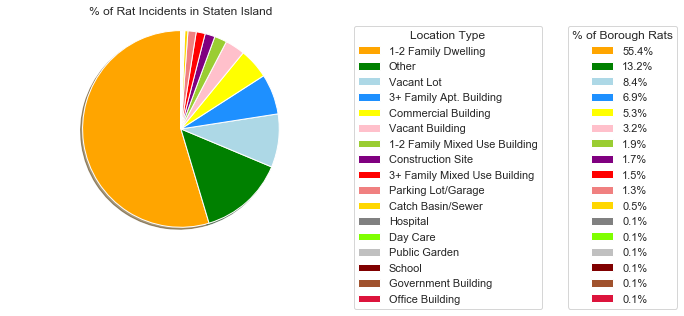

In [29]:
sizes = staten_island_df['Location Type'].value_counts()
explode = (0, .6, 0)
patches, texts = plt.pie(sizes, colors = colors5, shadow=True, startangle=90)
plt.title("% of Rat Incidents in Staten Island")
plt.axis("equal")
ninth_legend = plt.legend(patches, labels5, title = "Location Type", loc = "best", bbox_to_anchor = (1, 1))
ax = plt.gca().add_artist(ninth_legend)
tenth_legend = plt.legend(percentages5, title = "% of Borough Rats", loc = "best", bbox_to_anchor = (2, 1))
plt.show()

In [68]:
clean_df['Latitude'].replace('',np.nan, inplace=True)
clean_df['Longitude'].replace('', np.nan, inplace=True)

In [69]:
clean_df.dropna(subset=['Latitude'], inplace=True)
clean_df.dropna(subset=['Longitude'], inplace=True)

In [71]:
subway = "NYC_Transit_Subway_Entrance_And_Exit_Data.csv"
subway_df = pd.read_csv(subway)
subway_df

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Route2,Route3,Route4,Route5,...,ADA,ADA Notes,Free Crossover,North South Street,East West Street,Corner,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,False,NaN,False,4th Ave,25th St,SE,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)"
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,NaN,NaN,NaN,NaN,...,False,NaN,False,4th Ave,25th St,SW,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.998220)"
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,False,NaN,True,4th Ave,36th St,NW,40.654490,-74.004499,"(40.655144, -74.003549)","(40.654490, -74.004499)"
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,False,NaN,True,4th Ave,36th St,NE,40.654365,-74.004113,"(40.655144, -74.003549)","(40.654365, -74.004113)"
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,R,NaN,NaN,NaN,...,False,NaN,True,4th Ave,36th St,NW,40.654676,-74.004306,"(40.655144, -74.003549)","(40.654676, -74.004306)"
5,BMT,4 Avenue,45th St,40.648939,-74.010006,R,NaN,NaN,NaN,NaN,...,False,NaN,True,4th Ave,45th St,NE,40.649389,-74.009333,"(40.648939, -74.010006)","(40.649389, -74.009333)"
6,BMT,4 Avenue,45th St,40.648939,-74.010006,R,NaN,NaN,NaN,NaN,...,False,NaN,True,4th Ave,45th St,NW,40.649424,-74.009728,"(40.648939, -74.010006)","(40.649424, -74.009728)"
7,BMT,4 Avenue,45th St,40.648939,-74.010006,R,NaN,NaN,NaN,NaN,...,False,NaN,True,4th Ave,45th St,NE,40.649265,-74.009457,"(40.648939, -74.010006)","(40.649265, -74.009457)"
8,BMT,4 Avenue,45th St,40.648939,-74.010006,R,NaN,NaN,NaN,NaN,...,False,NaN,True,4th Ave,45th St,NW,40.649546,-74.009602,"(40.648939, -74.010006)","(40.649546, -74.009602)"
9,BMT,4 Avenue,53rd St,40.645069,-74.014034,R,NaN,NaN,NaN,NaN,...,False,NaN,True,4th Ave,53rd St,SW,40.644653,-74.014690,"(40.645069, -74.014034)","(40.644653, -74.014690)"


In [74]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [80]:

new_york_coordinates = (40.75, -74.00)
fig = gmaps.figure(center=new_york_coordinates, zoom_level=10)


locations = clean_df[['Latitude', 'Longitude']]
heatmap_layer = gmaps.heatmap_layer(locations)
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 5
fig.add_layer(heatmap_layer)



fig



Figure(layout=FigureLayout(height='420px'))

In [76]:
#subway and sightings combined

new_york_coordinates = (40.75, -74.00)
fig = gmaps.figure(center=new_york_coordinates, zoom_level=10)


locations = clean_df[['Latitude', 'Longitude']]
heatmap_layer = gmaps.heatmap_layer(locations)
heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 5
fig.add_layer(heatmap_layer)
plt.figure(figsize = (20,4))
station_locations = subway_df[['Station Latitude', 'Station Longitude']]

symbol_layer = gmaps.symbol_layer(station_locations, fill_color="blue", stroke_color="blue", scale=1)
fig.add_layer(symbol_layer)


fig

Figure(layout=FigureLayout(height='420px'))

<Figure size 1440x288 with 0 Axes>